In [1]:
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from abc import ABC, abstractmethod
import imageio
import glob
import pickle
import IPython
import os
from typing import Tuple, List
from collections import deque, namedtuple

Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])


In [2]:
env = gym.make('MountainCar-v0', max_episode_steps = 1000, render_mode="rgb_array")
env.action_space.seed(42)

42

Discrete(3)
Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
[-0.43395966  0.        ]
{}
[-4.3362388e-01  3.3578029e-04] -1.0 False False {}


<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


<class 'numpy.ndarray'>


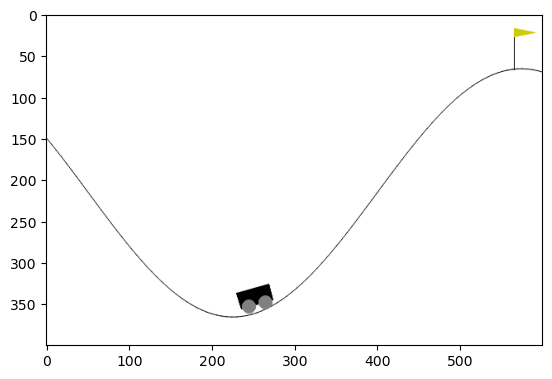

In [3]:
print(env.action_space)
print(env.observation_space)
#obs : position, velocity
obs, info = env.reset() # initial observation
print(obs)  
print(info)  
# take a step
action = 2  # Push right
obs, reward, terminated, truncated, info = env.step(action)
print(obs, reward, terminated, truncated, info)
#rendering
frame = env.render()
print(type(frame))  # <class 'numpy.ndarray'>
plt.imshow(frame)
plt.show()



In [4]:
# state space ranges from -1.2 to 0.6 for position and -0.07 to 0.07 for velocity
# action space is discrete with 3 possible actions
# reward is -1 for each time step until the goal position of 0.5 is reached

In [5]:
def discretize_state(state, agent):
    position, velocity = state
    
    # Create bins dynamically based on agent's n_bins
    position_bins = np.linspace(-1.2, 0.6, agent.n_bins_position)
    velocity_bins = np.linspace(-0.07, 0.07, agent.n_bins_velocity)

    position_index = np.digitize(position, position_bins) - 1
    velocity_index = np.digitize(velocity, velocity_bins) - 1

    return (position_index, velocity_index)


In [6]:
# initialize Q table
def initialize_q(n_bins_position, n_bins_velocity, n_actions):
    n_actions = env.action_space.n
    n_states = (n_bins_position, n_bins_velocity)
    Q = np.zeros(n_states + (n_actions,))
    return Q

In [7]:
# define all the agents
class BaseAgent(ABC):
    def __init__(self, action_dim:int, epsilon: float, gamma: float = 1.0,n_bins_position:int=20,n_bins_velocity:int=20):
        self.action_dim = action_dim
        self.epsilon = self.initial_epsilon = epsilon
        self.gamma = gamma
        self.n_bins_position = n_bins_position
        self.n_bins_velocity = n_bins_velocity
        self.Q = np.zeros((self.n_bins_position, self.n_bins_velocity, self.action_dim))  
        

    @abstractmethod
    def select_action(self, state) -> int:
        """Select an action given the state"""
        pass

    @abstractmethod
    def learn(self, *args, **kwargs) -> None:
        """Update Q-values based on learning method"""
        pass
    

    def select_action(self, state) -> int:
        if np.random.uniform() < self.epsilon:
            return np.random.choice(self.action_dim)
        else:
            return self.greedy_action(state)

    def greedy_action(self, state) -> int:
        action_values = self.Q[state[0], state[1], :]
        return np.argmax(action_values)  # Choose the best action

    def reset(self) -> None:
        self.Q = np.zeros((31, 100, self.action_dim))  # Reset Q-table
        self.epsilon = self.initial_epsilon

    def __getstate__(self):
        return self.__dict__.copy()

    def __setstate__(self, state):
        self.__dict__.update(state)


class TD0Agent(BaseAgent):  
    def __init__(self, action_dim, epsilon, alpha, gamma=1, offpolicy=False, n_bins_position=20, n_bins_velocity=20):
        super().__init__(action_dim, epsilon, gamma, n_bins_position, n_bins_velocity)
        self.offpolicy = offpolicy
        self.alpha = self.initial_alpha = alpha

    def reset(self):
        super().reset()
        self.alpha = self.initial_alpha

        
    #def learn(self, experience:Experience)->None:
    #    state, action, reward, next_state, done = experience
    #    if self.offpolicy:
    #        next_action = self.greedy_action(next_state) # q learning
    #    else:
    #        next_action = self.select_action(next_state) # sarsa

    #    next_max = self.Q[next_state[0],next_state[1], next_action] 
    
    #    self.Q[state][action] = self.Q[state][action] + self.alpha*(reward+  self.gamma*next_max - self.Q[state][action] )
    def learn(self, experience: Experience) -> None:
        state, action, reward, next_state, done = experience
        if self.offpolicy:
            next_action = self.greedy_action(next_state)  # Q-learning
        else:
            next_action = self.select_action(next_state)  # SARSA

        next_max = self.Q[next_state[0], next_state[1], next_action] 

        # Fix: Use correct Q-table indexing
        self.Q[state[0], state[1], action] += self.alpha * (
            reward + self.gamma * next_max - self.Q[state[0], state[1], action]
        )



class NstepSarsaAgent(BaseAgent):
    def __init__(self, action_dim, epsilon, alpha, gamma=1, n=3, n_bins_position=20, n_bins_velocity=20):
        super().__init__(action_dim, epsilon, gamma, n_bins_position, n_bins_velocity)
        self.alpha = self.initial_alpha = alpha
        self.n = n  # Number of steps
        self.memory = deque(maxlen=n+1)  # Store (state, action, reward)

    def reset(self):
        super().reset()
        self.alpha = self.initial_alpha
        self.memory.clear()

    def learn(self, experience:Experience):
        """
        Stores the current experience and updates Q-values when enough steps are collected.
        """
        _, _, _, _, done = experience
        self.memory.append(experience)

       

        if len(self.memory) < (self.n+1) and not done:  # if not reach terminal state: wait until enough steps are collected'
            return

        experiences = self.memory.copy()
        while len(experiences) > 0:
            G = 0 # Return
            for i, (_, _, r, _,_) in enumerate(experiences):
                G += (self.gamma ** (i+1)) * r  # Compute n-step return
           
            last_experience = experiences[-1]  # Last step
            next_state = last_experience.next_state
            next_action = self.select_action(next_state)
            Q_n = self.Q[next_state[0], next_state[1], next_action]
            G += (self.gamma ** self.n) * Q_n
           
            state, action, _, _, _ = experiences[0]
            td_error = G - self.Q[state[0], state[1], action] # Temporal difference error r_1*gamma^0 + r_2*gamma^1 + ... + r_n*gamma^(n-1) + Q(S_n, A_n) - Q(S_0, A_0)
            self.Q[state[0], state[1], action] += self.alpha * td_error
            experiences.popleft()
        
        if len(self.memory) >= self.n + 1:
            self.memory.popleft()
        if done:
            self.memory.clear()          

In [8]:
# Define the training loop
def train_agent(agent, env, total_episodes=10000, decay_fn=None):
    """
    Trains an agent (either MC or TD0) in MountainCar-v0.
    """
    time_outs = 0
    env.action_space.seed(42)

    with tqdm(total=total_episodes, desc="Training Progress") as pbar:
        for episode in range(total_episodes):
            state, _ = env.reset()
            state = discretize_state(state, agent)  # Ensure it's discrete

            done = False
            step = 0
            running_reward = 0

            while not done:
                step += 1
                action = agent.select_action(state)

                # Take action
                next_state, reward, terminated, truncated, _ = env.step(action)
                next_state = discretize_state(next_state,agent)
                done = terminated or truncated

                running_reward += reward
                experience = Experience(state, action, reward, next_state, done)
                agent.learn(experience)

                state = next_state

            # Apply decay to epsilon & alpha
            if decay_fn:
            #    agent.epsilon = decay_fn(episode, agent.initial_epsilon, total_episodes, A=0.5, B=0.2, C=0.001)
            #    if isinstance(agent, (TD0Agent, NstepSarsaAgent)):
            #        agent.alpha = decay_fn(episode, agent.initial_alpha, total_episodes, A=0.5, B=0.2, C=0.00001)
                agent.epsilon = decay_fn(episode, agent.initial_epsilon, total_episodes)


            if episode % 100 == 0:
                state_check = (15, 10)  # Example state
                print(f"Q-values at {state_check}: {agent.Q[state_check]}")
                best_action = np.argmax(agent.Q[state_check])

                print(f"Preferred action at {state_check}: {best_action}")  # Should become 2
                action_counts = [0, 0, 0]  # Left, stay, right
                for _ in range(100):
                    test_state, _ = env.reset()
                    test_state = discretize_state(test_state, agent)
                    action = agent.greedy_action(test_state)
                    action_counts[action] += 1
                print(f"Episode {episode} Action Distribution: {action_counts}")

            # Logging
            pbar.set_postfix({"steps": step, "epsilon": agent.epsilon, "Running Return": running_reward})
            pbar.update(1)



def get_trajectory(agent:BaseAgent,env:gym.Env, filename:str):
    print("Creating video...")
    video_folder = "videos"
    if not os.path.exists(video_folder):
        os.makedirs(video_folder)
    trajectory = []
    env = gym.wrappers.RecordVideo(env, video_folder=video_folder, name_prefix=filename)
    observation, info = env.reset()
    observation = discretize_state(observation,agent)


    while True:
        env.render()
        state = discretize_state(observation,agent)
        trajectory.append(state)
        action = agent.greedy_action(state)

        observation, reward, terminated, truncated, info = env.step(action)
        observation = discretize_state(observation,agent)
        if terminated or truncated:
            env.render()
            break
    
    state = discretize_state(observation,agent)
    trajectory.append(state)
    env.close()
    print("Video saved.")
    video_files = sorted(
        [f for f in os.listdir(video_folder) if f.endswith(".mp4") and f.startswith(filename)],
        key=lambda f: os.path.getmtime(os.path.join(video_folder, f)),  # Sort by creation time
        reverse=True
    )
    video_path = os.path.join(video_folder, video_files[0])
    IPython.display.display(IPython.display.Video(video_path))
    return trajectory



def visualize_policy(agent, env, trajectory=None):
    """
    Visualizes the learned policy of an agent in a given environment.

    Parameters:
    - agent: The trained RL agent with Q-values and greedy policy.
    - env: The environment object, which should contain a MAP attribute and action mapping.
    - trajectory: A list of visited (state_x, state_y) pairs, showing an example path (optional).
    """
    fig, ax = plt.subplots(figsize=(20, 16), dpi=300)

    # Display environment map
    ax.imshow(env.unwrapped.MAP, cmap="gray")

    # Draw finish line (goal area)
    plt.plot(np.full(fill_value=99, shape=31), np.arange(31), color="#32CD32", linewidth=10)

    # Print max Q-value for a sample state
    print(f"Max Q-value at (15,0): {np.max(agent.Q[15, 0, :])}")

    # If a trajectory is provided, plot the agent's path
    if trajectory:
        path_x = [x for _, x in trajectory]
        path_y = [y for y, _ in trajectory]
        ax.plot(path_x, path_y, color="blue", linewidth=2)

    # Draw policy arrows (greedy actions)
    for i in range(31):
        for j in range(99):
            action = agent.greedy_action((i, j))  # Get best action
            dy, dx = env.unwrapped.action_to_direction[action]  # Convert action to movement direction
            ax.arrow(j - dx * 0.25, i - dy * 0.25, dx * 0.25, dy * 0.25, 
                     head_width=0.25, head_length=0.25, color="red")

    plt.title("Learned Policy Visualization")
    plt.show()


In [9]:
def decay(time:int, start_value:float, n_episodes:int,A:float=0.8,B:float=0.3,C:float=0.2, lower_bound:float = 0.01):
        standardized_time=(time-A*n_episodes)/(B*n_episodes)
        csh = np.cosh(np.exp(-standardized_time))
        epsilon=1.1-(1/csh+(time*C/n_episodes))
        return max(epsilon*start_value, lower_bound)

In [10]:
# decay 2
def decay_epsilon(episode, initial_epsilon=1.0, total_episodes=10000, min_epsilon=0.01):
    return max(initial_epsilon * (0.999 ** episode), min_epsilon)



# train 2
# Define the training loop with suggested parameters from hælfi with seperate rendering environment
env2 = gym.make('MountainCar-v0', max_episode_steps = 1000)
env2.action_space.seed(42)
def train(agent, env, total_episodes=10000):
    """
    Trains an agent in MountainCar-v0 without rendering (to improve speed).
    """
    env.action_space.seed(42)

    with tqdm(total=total_episodes, desc="Training Progress") as pbar:
        for episode in range(total_episodes):
            state, _ = env.reset()
            state = discretize_state(state, agent)

            done = False
            step = 0
            running_reward = 0

            while not done:
                step += 1
                action = agent.select_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                next_state = discretize_state(next_state, agent)
                done = terminated or truncated

                # Store experience and update Q-table
                experience = Experience(state, action, reward, next_state, done)
                agent.learn(experience)
                state = next_state

            if episode % 1000 == 0:
                state_check = (15, 10)  # Example state
                best_action = np.argmax(agent.Q[state_check])
                print(f"Q-values at {state_check}: {agent.Q[state_check]}")
                print(f"Preferred action at {state_check}: {best_action}")  # Should become 2


            # Decay epsilon
            agent.epsilon = max(agent.epsilon * 0.995, 0.01)  # Ensure epsilon does not go below 0.01

            # Logging progress
            pbar.set_postfix({"steps": step, "epsilon": agent.epsilon, "Running Return": running_reward})
            pbar.update(1)


# Create Q-learning agent with suggested parameters
agent_q = TD0Agent(
    action_dim=3,          
    epsilon=1.0,           # Start with full exploration
    alpha=0.1,             # Learning rate
    gamma=0.9,             # Slightly lower discount factor
    offpolicy=True,        
    n_bins_position=40,    
    n_bins_velocity=40     
)

# Train the agent
train(agent_q, env2, total_episodes=10000)


# Create a separate environment for rendering
render_env = gym.make("MountainCar-v0", render_mode="rgb_array")

# Visualize the learned policy
trajectory = get_trajectory(agent_q, render_env, "trained_agent_render")



## 20 bins for position and velocity

In [11]:
env = gym.make('MountainCar-v0', max_episode_steps=1000, render_mode=None)
env.action_space.seed(42)
# Create Q-learning agent (off-policy)
agent_q = TD0Agent(
    action_dim=3,          
    epsilon=1.0,           
    alpha=0.3,  # Lower learning rate for more stable updates            
    gamma=0.85,  # Keep gamma lowered for short-term improvements  
    offpolicy=True,        
    n_bins_position=30,    
    n_bins_velocity=30     
)



# Train the Q-learning agent
train_agent(agent_q, env, total_episodes=5000, decay_fn=decay_epsilon)


Training Progress:   0%|          | 4/5000 [00:00<03:45, 22.18it/s, steps=1000, epsilon=0.996, Running Return=-1e+3]

Q-values at (15, 10): [-0.3 -0.3  0. ]
Preferred action at (15, 10): 2
Episode 0 Action Distribution: [22, 33, 45]


Training Progress:   2%|▏         | 104/5000 [00:05<04:15, 19.18it/s, steps=1000, epsilon=0.902, Running Return=-1e+3]

Q-values at (15, 10): [-5.59476202 -5.67526257 -5.79586072]
Preferred action at (15, 10): 0
Episode 100 Action Distribution: [57, 0, 43]


Training Progress:   4%|▍         | 203/5000 [00:10<04:05, 19.58it/s, steps=1000, epsilon=0.816, Running Return=-1e+3]

Q-values at (15, 10): [-6.26740595 -6.31233037 -6.28442595]
Preferred action at (15, 10): 0
Episode 200 Action Distribution: [24, 0, 76]


Training Progress:   6%|▌         | 305/5000 [00:15<03:26, 22.72it/s, steps=976, epsilon=0.738, Running Return=-976]  

Q-values at (15, 10): [-6.54639724 -6.53961702 -6.56109572]
Preferred action at (15, 10): 1
Episode 300 Action Distribution: [25, 0, 75]


Training Progress:   8%|▊         | 407/5000 [00:19<02:37, 29.21it/s, steps=514, epsilon=0.666, Running Return=-514]  

Q-values at (15, 10): [-6.61254479 -6.61676286 -6.63809598]
Preferred action at (15, 10): 0
Episode 400 Action Distribution: [62, 10, 28]


Training Progress:  10%|█         | 506/5000 [00:22<02:32, 29.56it/s, steps=352, epsilon=0.603, Running Return=-352]  

Q-values at (15, 10): [-6.64136297 -6.64705976 -6.64786157]
Preferred action at (15, 10): 0
Episode 500 Action Distribution: [86, 0, 14]


Training Progress:  12%|█▏        | 607/5000 [00:26<02:20, 31.34it/s, steps=338, epsilon=0.545, Running Return=-338]  

Q-values at (15, 10): [-6.65362801 -6.6544158  -6.65658407]
Preferred action at (15, 10): 0
Episode 600 Action Distribution: [64, 0, 36]


Training Progress:  14%|█▍        | 708/5000 [00:28<01:40, 42.71it/s, steps=646, epsilon=0.492, Running Return=-646]

Q-values at (15, 10): [-6.65945856 -6.65926825 -6.65922733]
Preferred action at (15, 10): 2
Episode 700 Action Distribution: [60, 0, 40]


Training Progress:  16%|█▌        | 811/5000 [00:30<01:15, 55.33it/s, steps=288, epsilon=0.444, Running Return=-288]

Q-values at (15, 10): [-6.65991705 -6.66248912 -6.66270436]
Preferred action at (15, 10): 0
Episode 800 Action Distribution: [56, 9, 35]


Training Progress:  18%|█▊        | 912/5000 [00:32<01:08, 59.62it/s, steps=252, epsilon=0.402, Running Return=-252]

Q-values at (15, 10): [-6.66360246 -6.66352394 -6.66371806]
Preferred action at (15, 10): 1
Episode 900 Action Distribution: [56, 0, 44]


Training Progress:  20%|██        | 1013/5000 [00:34<01:00, 66.03it/s, steps=350, epsilon=0.363, Running Return=-350]

Q-values at (15, 10): [-6.66367661 -6.66340711 -6.66366738]
Preferred action at (15, 10): 1
Episode 1000 Action Distribution: [57, 12, 31]


Training Progress:  22%|██▏       | 1113/5000 [00:35<00:58, 66.04it/s, steps=248, epsilon=0.328, Running Return=-248]

Q-values at (15, 10): [-6.6640754  -6.6638001  -6.66383092]
Preferred action at (15, 10): 1
Episode 1100 Action Distribution: [90, 0, 10]


Training Progress:  24%|██▍       | 1212/5000 [00:37<01:00, 62.21it/s, steps=274, epsilon=0.297, Running Return=-274]

Q-values at (15, 10): [-6.66469135 -6.66369319 -6.66278087]
Preferred action at (15, 10): 2
Episode 1200 Action Distribution: [89, 0, 11]


Training Progress:  26%|██▌       | 1311/5000 [00:38<00:57, 64.06it/s, steps=269, epsilon=0.269, Running Return=-269]

Q-values at (15, 10): [-6.66471685 -6.66466022 -6.66468661]
Preferred action at (15, 10): 1
Episode 1300 Action Distribution: [58, 0, 42]


Training Progress:  28%|██▊       | 1413/5000 [00:40<00:53, 67.63it/s, steps=732, epsilon=0.243, Running Return=-732]

Q-values at (15, 10): [-6.66449521 -6.66538647 -6.66526881]
Preferred action at (15, 10): 0
Episode 1400 Action Distribution: [58, 0, 42]


Training Progress:  30%|███       | 1515/5000 [00:41<00:42, 81.69it/s, steps=294, epsilon=0.22, Running Return=-294] 

Q-values at (15, 10): [-6.66507933 -6.6655402  -6.66557579]
Preferred action at (15, 10): 0
Episode 1500 Action Distribution: [66, 0, 34]


Training Progress:  32%|███▏      | 1611/5000 [00:43<00:51, 66.07it/s, steps=368, epsilon=0.2, Running Return=-368]  

Q-values at (15, 10): [-6.66558417 -6.66571856 -6.66571997]
Preferred action at (15, 10): 0
Episode 1600 Action Distribution: [90, 0, 10]


Training Progress:  34%|███▍      | 1708/5000 [00:44<00:53, 62.11it/s, steps=1000, epsilon=0.181, Running Return=-1e+3]

Q-values at (15, 10): [-6.6660513  -6.66612198 -6.66608585]
Preferred action at (15, 10): 0
Episode 1700 Action Distribution: [53, 0, 47]


Training Progress:  36%|███▋      | 1813/5000 [00:46<00:50, 63.15it/s, steps=312, epsilon=0.163, Running Return=-312]  

Q-values at (15, 10): [-6.66592136 -6.66596042 -6.66607643]
Preferred action at (15, 10): 0
Episode 1800 Action Distribution: [53, 16, 31]


Training Progress:  38%|███▊      | 1916/5000 [00:47<00:39, 77.32it/s, steps=322, epsilon=0.147, Running Return=-322]

Q-values at (15, 10): [-6.66614726 -6.66626644 -6.6662476 ]
Preferred action at (15, 10): 0
Episode 1900 Action Distribution: [91, 0, 9]


Training Progress:  40%|████      | 2015/5000 [00:49<00:41, 71.43it/s, steps=226, epsilon=0.133, Running Return=-226]

Q-values at (15, 10): [-6.66622878 -6.66622805 -6.6662376 ]
Preferred action at (15, 10): 1
Episode 2000 Action Distribution: [57, 0, 43]


Training Progress:  42%|████▏     | 2113/5000 [00:50<00:39, 73.03it/s, steps=453, epsilon=0.121, Running Return=-453]

Q-values at (15, 10): [-6.66622124 -6.66635092 -6.66633968]
Preferred action at (15, 10): 0
Episode 2100 Action Distribution: [61, 0, 39]


Training Progress:  44%|████▍     | 2217/5000 [00:51<00:34, 81.15it/s, steps=241, epsilon=0.109, Running Return=-241]

Q-values at (15, 10): [-6.66638586 -6.66639337 -6.66639992]
Preferred action at (15, 10): 0
Episode 2200 Action Distribution: [62, 0, 38]


Training Progress:  46%|████▋     | 2317/5000 [00:52<00:28, 93.27it/s, steps=228, epsilon=0.0985, Running Return=-228]

Q-values at (15, 10): [-6.66640157 -6.66641786 -6.66639992]
Preferred action at (15, 10): 2
Episode 2300 Action Distribution: [66, 0, 34]


Training Progress:  48%|████▊     | 2416/5000 [00:54<00:30, 85.95it/s, steps=188, epsilon=0.0892, Running Return=-188]

Q-values at (15, 10): [-6.66647772 -6.66647219 -6.66646649]
Preferred action at (15, 10): 2
Episode 2400 Action Distribution: [60, 0, 40]


Training Progress:  50%|█████     | 2516/5000 [00:55<00:32, 76.11it/s, steps=163, epsilon=0.0808, Running Return=-163]  

Q-values at (15, 10): [-6.66647772 -6.66639355 -6.66648203]
Preferred action at (15, 10): 1
Episode 2500 Action Distribution: [61, 0, 39]


Training Progress:  52%|█████▏    | 2617/5000 [00:56<00:24, 98.03it/s, steps=251, epsilon=0.0729, Running Return=-251] 

Q-values at (15, 10): [-6.66651119 -6.66651414 -6.66650507]
Preferred action at (15, 10): 2
Episode 2600 Action Distribution: [30, 35, 35]


Training Progress:  54%|█████▍    | 2719/5000 [00:57<00:35, 63.95it/s, steps=254, epsilon=0.0659, Running Return=-254]   

Q-values at (15, 10): [-6.66646766 -6.66651414 -6.6665149 ]
Preferred action at (15, 10): 0
Episode 2700 Action Distribution: [53, 11, 36]


Training Progress:  56%|█████▋    | 2814/5000 [00:59<00:29, 75.29it/s, steps=371, epsilon=0.0599, Running Return=-371]  

Q-values at (15, 10): [-6.66620783 -6.66651414 -6.66651436]
Preferred action at (15, 10): 0
Episode 2800 Action Distribution: [66, 0, 34]


Training Progress:  58%|█████▊    | 2918/5000 [01:00<00:23, 88.64it/s, steps=181, epsilon=0.054, Running Return=-181] 

Q-values at (15, 10): [-6.66649586 -6.66651092 -6.66650964]
Preferred action at (15, 10): 0
Episode 2900 Action Distribution: [54, 9, 37]


Training Progress:  60%|██████    | 3019/5000 [01:01<00:20, 95.11it/s, steps=169, epsilon=0.0488, Running Return=-169]

Q-values at (15, 10): [-6.6664596  -6.66651092 -6.66650964]
Preferred action at (15, 10): 0
Episode 3000 Action Distribution: [18, 0, 82]


Training Progress:  62%|██████▏   | 3121/5000 [01:02<00:18, 101.90it/s, steps=153, epsilon=0.044, Running Return=-153] 

Q-values at (15, 10): [-6.66652163 -6.66654142 -6.66653706]
Preferred action at (15, 10): 0
Episode 3100 Action Distribution: [92, 0, 8]


Training Progress:  64%|██████▍   | 3220/5000 [01:03<00:18, 96.48it/s, steps=269, epsilon=0.0399, Running Return=-269] 

Q-values at (15, 10): [-6.66655654 -6.66656145 -6.66656471]
Preferred action at (15, 10): 0
Episode 3200 Action Distribution: [30, 37, 33]


Training Progress:  66%|██████▋   | 3322/5000 [01:04<00:15, 107.57it/s, steps=218, epsilon=0.036, Running Return=-218] 

Q-values at (15, 10): [-6.66650448 -6.66656165 -6.66655817]
Preferred action at (15, 10): 0
Episode 3300 Action Distribution: [92, 0, 8]


Training Progress:  68%|██████▊   | 3414/5000 [01:05<00:19, 81.30it/s, steps=530, epsilon=0.0329, Running Return=-530] 

Q-values at (15, 10): [-6.66650966 -6.66656165 -6.66655817]
Preferred action at (15, 10): 0
Episode 3400 Action Distribution: [29, 28, 43]


Training Progress:  70%|███████   | 3517/5000 [01:06<00:15, 93.64it/s, steps=200, epsilon=0.0296, Running Return=-200]

Q-values at (15, 10): [-6.66651517 -6.66656165 -6.66655817]
Preferred action at (15, 10): 0
Episode 3500 Action Distribution: [59, 0, 41]


Training Progress:  72%|███████▏  | 3617/5000 [01:07<00:16, 84.33it/s, steps=194, epsilon=0.0268, Running Return=-194]

Q-values at (15, 10): [-6.66654987 -6.66656375 -6.66656315]
Preferred action at (15, 10): 0
Episode 3600 Action Distribution: [59, 0, 41]


Training Progress:  74%|███████▍  | 3714/5000 [01:08<00:15, 84.07it/s, steps=223, epsilon=0.0243, Running Return=-223]

Q-values at (15, 10): [-6.66656009 -6.66656375 -6.66656315]
Preferred action at (15, 10): 0
Episode 3700 Action Distribution: [26, 29, 45]


Training Progress:  76%|███████▋  | 3817/5000 [01:10<00:12, 92.30it/s, steps=251, epsilon=0.022, Running Return=-251] 

Q-values at (15, 10): [-6.66657682 -6.66658762 -6.66658721]
Preferred action at (15, 10): 0
Episode 3800 Action Distribution: [61, 0, 39]


Training Progress:  78%|███████▊  | 3919/5000 [01:11<00:11, 95.29it/s, steps=193, epsilon=0.0198, Running Return=-193]

Q-values at (15, 10): [-6.66658963 -6.66658762 -6.6665926 ]
Preferred action at (15, 10): 1
Episode 3900 Action Distribution: [61, 0, 39]


Training Progress:  80%|████████  | 4019/5000 [01:12<00:09, 101.46it/s, steps=310, epsilon=0.0179, Running Return=-310]

Q-values at (15, 10): [-6.66659748 -6.66659118 -6.6665926 ]
Preferred action at (15, 10): 1
Episode 4000 Action Distribution: [75, 0, 25]


Training Progress:  82%|████████▏ | 4117/5000 [01:13<00:10, 87.36it/s, steps=195, epsilon=0.0163, Running Return=-195] 

Q-values at (15, 10): [-6.66660723 -6.66660742 -6.66660846]
Preferred action at (15, 10): 0
Episode 4100 Action Distribution: [29, 29, 42]


Training Progress:  84%|████████▍ | 4222/5000 [01:14<00:07, 105.81it/s, steps=169, epsilon=0.0146, Running Return=-169]

Q-values at (15, 10): [-6.66659983 -6.66660742 -6.66660846]
Preferred action at (15, 10): 0
Episode 4200 Action Distribution: [28, 28, 44]


Training Progress:  86%|████████▋ | 4319/5000 [01:15<00:07, 88.05it/s, steps=191, epsilon=0.0133, Running Return=-191] 

Q-values at (15, 10): [-6.66662232 -6.66662466 -6.66662521]
Preferred action at (15, 10): 0
Episode 4300 Action Distribution: [56, 0, 44]


Training Progress:  88%|████████▊ | 4416/5000 [01:16<00:07, 82.31it/s, steps=191, epsilon=0.0121, Running Return=-191]

Q-values at (15, 10): [-6.66663129 -6.66663391 -6.66663383]
Preferred action at (15, 10): 0
Episode 4400 Action Distribution: [31, 0, 69]


Training Progress:  90%|█████████ | 4520/5000 [01:17<00:05, 93.66it/s, steps=228, epsilon=0.0109, Running Return=-228]

Q-values at (15, 10): [-6.66664017 -6.66663926 -6.66663783]
Preferred action at (15, 10): 2
Episode 4500 Action Distribution: [58, 0, 42]


Training Progress:  92%|█████████▏| 4621/5000 [01:18<00:03, 104.53it/s, steps=152, epsilon=0.01, Running Return=-152]  

Q-values at (15, 10): [-6.66664224 -6.66664246 -6.66663733]
Preferred action at (15, 10): 2
Episode 4600 Action Distribution: [58, 0, 42]


Training Progress:  94%|█████████▍| 4723/5000 [01:19<00:02, 99.34it/s, steps=175, epsilon=0.01, Running Return=-175] 

Q-values at (15, 10): [-6.66660252 -6.66664246 -6.66664279]
Preferred action at (15, 10): 0
Episode 4700 Action Distribution: [27, 0, 73]


Training Progress:  96%|█████████▋| 4821/5000 [01:20<00:01, 111.08it/s, steps=157, epsilon=0.01, Running Return=-157]

Q-values at (15, 10): [-6.66661975 -6.66664246 -6.66664279]
Preferred action at (15, 10): 0
Episode 4800 Action Distribution: [55, 0, 45]


Training Progress:  98%|█████████▊| 4921/5000 [01:21<00:00, 109.50it/s, steps=166, epsilon=0.01, Running Return=-166]

Q-values at (15, 10): [-6.66661005 -6.66664246 -6.66664279]
Preferred action at (15, 10): 0
Episode 4900 Action Distribution: [24, 0, 76]


Training Progress: 100%|██████████| 5000/5000 [01:22<00:00, 60.62it/s, steps=171, epsilon=0.01, Running Return=-171] 


In [13]:
# Create a separate environment for rendering
render_env = gym.make("MountainCar-v0", render_mode="rgb_array")

# Generate trajectory
trajectory_agent_q = get_trajectory(agent_q, render_env, "agent_q")


Creating video...
Video saved.


In [ ]:
trajectory_agent_q = get_trajectory(agent_q, env, "agent_q")

In [ ]:
# Create SARSA agent (on-policy)
agent_sarsa = TD0Agent(
    action_dim=3,          
    epsilon=1.0,           
    alpha=0.1,             
    gamma=0.99,            
    offpolicy=False,       
    n_bins_position=25,    
    n_bins_velocity=25     
)

# Train the SARSA agent
train_agent(agent_sarsa, env, total_episodes=5000)


In [ ]:
trajectory_sarsa = get_trajectory(agent_sarsa, env, "agent_sarsa")

In [ ]:
# Create N-Step SARSA agent
agent_nstep_sarsa = NstepSarsaAgent(
    action_dim=3,          
    epsilon=1.0,           
    alpha=0.1,             
    gamma=0.99,            
    n=3,                   
    n_bins_position=20,    
    n_bins_velocity=20     
)

# Train the N-step SARSA agent
train_agent(agent_nstep_sarsa, env, total_episodes=5000)


In [ ]:
trajectory_nstep_sarsa = get_trajectory(agent_nstep_sarsa, env, "agent_nstep_sarsa")

## 30 bins for position and 30 bins for velocity

In [ ]:
# Create Q-learning agent (off-policy)
agent_q2 = TD0Agent(
    action_dim=3,          
    epsilon=1.0,           
    alpha=0.1,             
    gamma=0.99,            
    offpolicy=True,        
    n_bins_position=30,    
    n_bins_velocity=30     
)

# Train the Q-learning agent
train_agent(agent_q2, env, total_episodes=5000)


In [ ]:
trajectory_agent_q2 = get_trajectory(agent_q2, env, "agent_q2")

In [ ]:
# Create SARSA agent (on-policy)
agent_sarsa2 = TD0Agent(
    action_dim=3,          
    epsilon=1.0,           
    alpha=0.1,             
    gamma=0.99,            
    offpolicy=False,       
    n_bins_position=30,    
    n_bins_velocity=30     
)

# Train the SARSA agent
train_agent(agent_sarsa, env, total_episodes=5000)


In [ ]:
trajectory_sarsa2 = get_trajectory(agent_sarsa2, env, "agent_sarsa2")

In [ ]:
# Create N-Step SARSA agent
agent_nstep_sarsa2 = NstepSarsaAgent(
    action_dim=3,          
    epsilon=1.0,           
    alpha=0.1,             
    gamma=0.99,            
    n=3,                   
    n_bins_position=30,    
    n_bins_velocity=30     
)

# Train the N-step SARSA agent
train_agent(agent_nstep_sarsa, env, total_episodes=5000)


In [ ]:
trajectory_nstep_sarsa2 = get_trajectory(agent_nstep_sarsa2, env, "agent_nstep_sarsa2")

# Chat for evaluation (Ikke prøvd)

In [ ]:
for bins in [10, 20, 30, 40, 50]:  # Test different discretizations
    print(f"\nTraining with n_bins = {bins}")

    agent_q = TD0Agent(
        action_dim=3, epsilon=1.0, alpha=0.1, gamma=0.99,
        offpolicy=True,  # Q-learning
        n_bins_position=bins, n_bins_velocity=bins
    )
    train_agent(agent_q, env, total_episodes=10_000)

    agent_sarsa = TD0Agent(
        action_dim=3, epsilon=1.0, alpha=0.1, gamma=0.99,
        offpolicy=False,  # SARSA
        n_bins_position=bins, n_bins_velocity=bins
    )
    train_agent(agent_sarsa, env, total_episodes=10_000)


In [ ]:
for agent, label in zip([agent_q, agent_sarsa], ["Q-learning", "SARSA"]):
    print(f"\nTesting {label} with bins={bins}")
    trajectory = get_trajectory(agent, env, f"mountaincar_{label}_bins{bins}")


In [ ]:
# other feature engineering
# Tile encoding
# Normalizing input
# Reward shaping